### 1. Sekcja odczytywania danych, określania typów danych cech.

In [2]:
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import KBinsDiscretizer
import numpy as np
import matplotlib.pyplot as plt


target_var: str = "CO2 Emissions(g/km)" #To jest nazwa zmiennej docelowej.
target_var_discr: str = "CO2 Emissions(g/km)_disc" #To jest nazwa zmiennej docelowej, która została poddana proceowi dyskretyzacji.

dtypes = { "Make": "category", #Określ typ danych każdej cechy w ramce danych, która zostanie zaraz odczytana.
            "Model":"category",
            "Vehicle Class":"category",
            "Engine Size(L)":"float",
            "Cylinders":"category",
            "Transmission":"category",
            "Fuel Type":"category",
            "Fuel Consumption City (L/100 km)":np.float64,
            "Fuel Consumption Hwy (L/100 km)":np.float64,
            "Fuel Consumption Comb (L/100 km)":np.float64,
            "Fuel Consumption Comb (mpg)":np.float64,
            "CO2 Emissions(g/km)":np.float64}

def ReadDataFrame(filename:str, sep:str =';') -> tuple[pd.DataFrame, int]:
    global dtypes
   
    Dataset = pd.read_csv(filename,
                        sep=sep, dtype = dtypes, decimal = ",") #Wczytaj plik z danymi.

    n_rows:int  = Dataset.shape[0] #Liczba wszystkich wierszy w ramce danych

    return Dataset, n_rows




def FindTargetVarCol(Dataset:pd.DataFrame, target_var:str) -> np.ndarray:
    """Funkcja wybiera kolumne docelową z ramki danych, konwertuje ją na tablice numpy i zmienia liczbe jej wymiarów, tak
    aby zwrócona tablica była kompatybilna z modelami z sklearn'a."""

    return Dataset[target_var].to_numpy().reshape(-1,1)



Dataset, n_rows = ReadDataFrame("CO2Emission.csv")
target_var_col = FindTargetVarCol(Dataset, target_var)




### 2. Sekcja statystyki opisowej zmiennych kategorycznych

### Częstość występowania  unikatowych klas dla danej zmiennej.

502


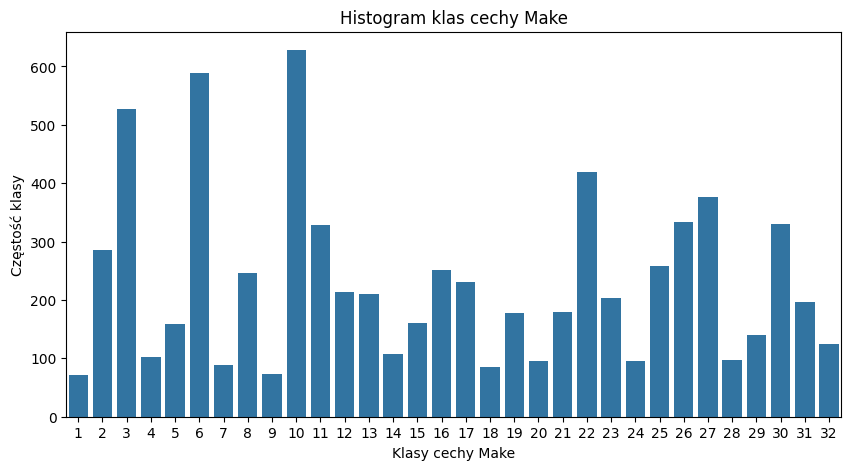

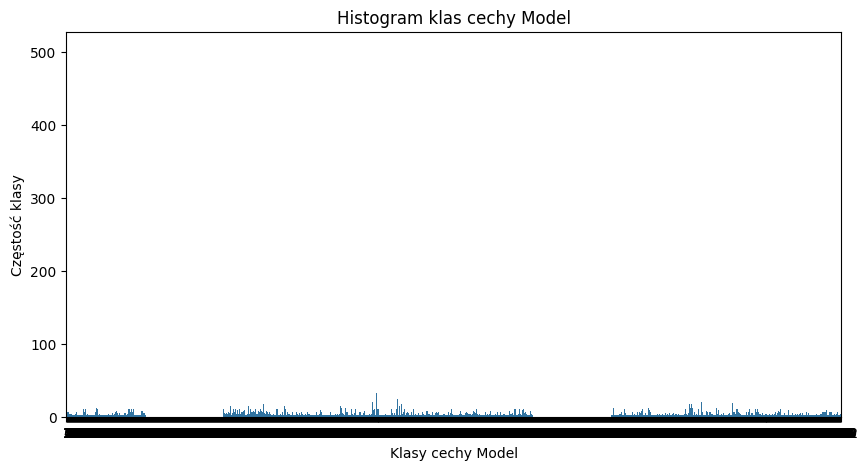

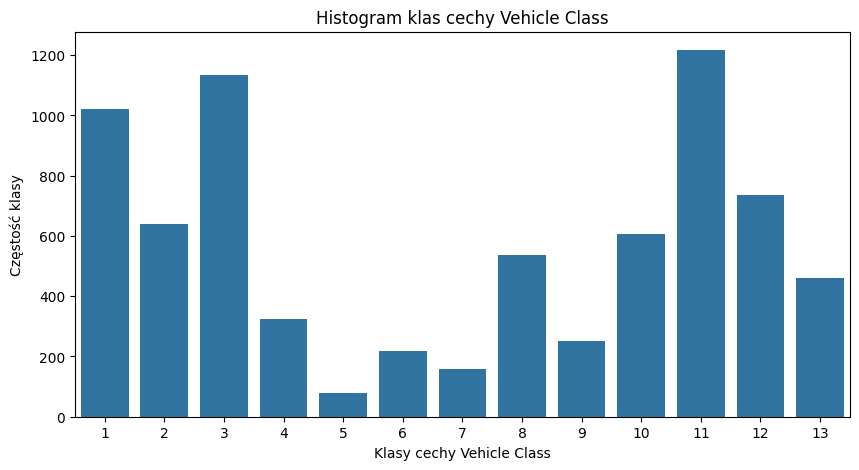

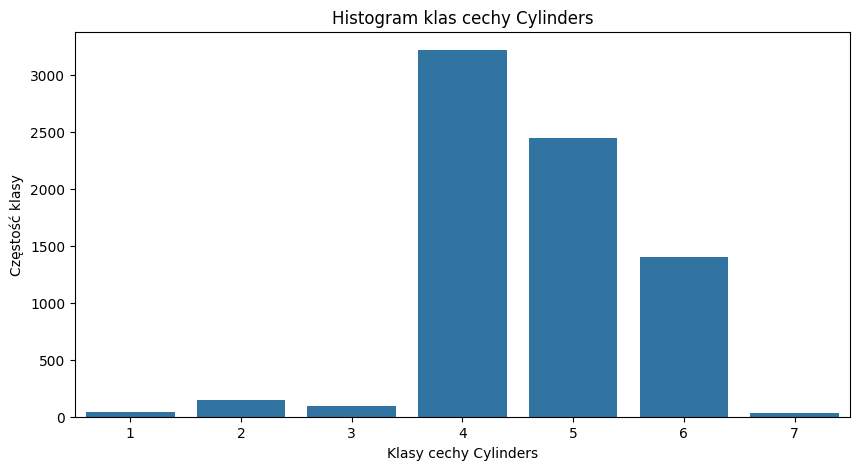

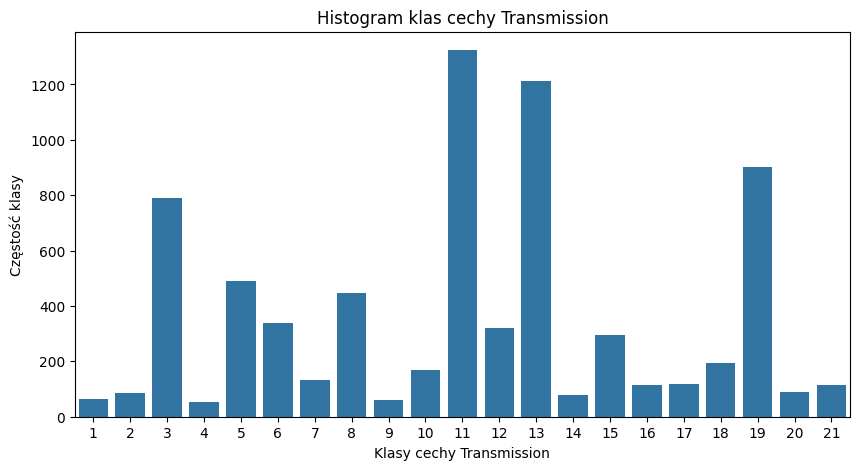

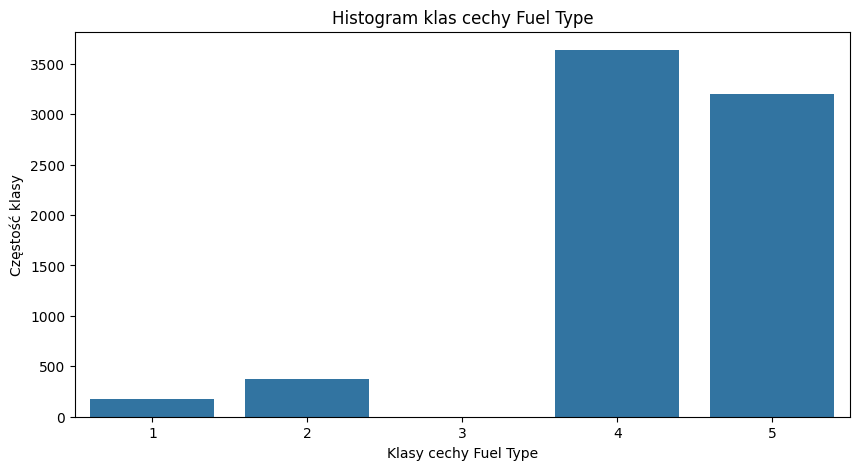

In [3]:
def CreateHistogram(Dataset:pd.DataFrame, CatFeature:str) ->  pd.DataFrame:
    """Funkcja dla każdej unikatowej klasy z cechy CatFeature wylicza liczbę jej wystapień.
    Wynikiem funkcji jest pandowska ramka danych, która zawiera trzy kolumny o nazwach odpowiednio: 'CatFeature', 'CatFeature_coded' oraz 'count'.
    Kolumna CatFeature_coded zawiera zakodowane nazwy klas w postaci liczb całkowitych. Taka forma ułatwia odczytywanie etykiet na wykresach.
    """

    Histogram:pd.DataFrame = Dataset[CatFeature].value_counts(sort = False,).reset_index() #Stwórz proste podsumowanie częstotliwości występowania klas.

    return  Histogram

def CreateHistPlot(Histogram:pd.DataFrame, CatFeature:str) -> None:

    """Zadaniem tej funkcji jest stworzenie wykresu histogramowego, który opisze częstowliwość występowania wszystkich klas z cechy 'CatFeature'"""
    plt.figure(figsize = (10,5)) #Stwórz płótno, na którym  będzie rysowany wykres
 
    axes = sns.barplot(data = Histogram, x = f"{CatFeature}_coded", y = "count") #Czas na słupkowanie.

    axes.set_xlabel(f"Klasy cechy {CatFeature}") #Ustaw etykietkę poziomej osi.
    axes.set_ylabel(f"Częstość klasy") #Ustaw etykietke pionowej osi.

    axes.set_title(f"Histogram klas cechy {CatFeature}") #Ustaw tytuł wykresu.

    axes.set_ylim(0, 1.05*np.max(Histogram['count']))

    


def AggregateRarestClass(Histogram:pd.DataFrame, CatFeature:str) -> pd.DataFrame:
    """Niektóre klasy danej cechy pojawią się bardzo rzadko. W tym celu niespotykane często klasy zagregujemy w jedną klasę o nazwie Other.
    Taki cel przyswięca funkcji tej. Klasa jest uznawana za rzadką, jeżeli liczba jej wystapień jest mniejsza niż frequency_threshold
    """
    frequecy_threshold:float = Histogram['count'].quantile(q = 0.25)

    Histogram[CatFeature] = Histogram.apply(func = lambda row: row[CatFeature] if row["count"]>=frequecy_threshold else "Other", 
                    axis = 1) #Klasy, które występują rzadziej niż frequency_threshold sklasyfikuj jako "other".
    

    Histogram:pd.DataFrame =   Histogram.groupby(by = CatFeature, 
                            as_index = False).agg(func = {"count":"sum"}) #Aktualnie w ramce Histogram tylko klasa "Other" może pojawiać się więcej 
                                                                            #Niż jeden raz. Zsumuj liczby wystąpień dla obserwacji, które są "inne".
    
    Unique_class_count:int = Histogram.shape[0]
    
    Histogram.insert(loc = 1, column = f"{CatFeature}_coded", value = range(1, Unique_class_count + 1 ))

    return Histogram



CatFeatures: list[str] = Dataset.select_dtypes(include = "category").columns #Znajdź listę wszystkich cech kategorycznych.


for CatFeature in CatFeatures:

    Histogram = CreateHistogram(Dataset = Dataset,  #Znajdź histogram unikatowych klas dla zmiennej CatFeature.
                                CatFeature = CatFeature) 


    Histogram = AggregateRarestClass(Histogram = Histogram, 
                                     CatFeature = CatFeature) #Zagreguj rzadkie klasy.
    

    CreateHistPlot(Histogram = Histogram,  #Rysuj wykresik, bo kochamy wykresy.
                  CatFeature = CatFeature)



## 3. Pierwsze wnioski, jakie można wysunąć:


### Zmienna make może zostać skasowana. Nie jest ona dobrą zmienną, którą można uwzględnić w modela, z powodu ogromnej liczby unikatowych klas (ponad 2000), co czyni ją niemalże zmienną identyfikującą.

### Obserwacja, której typ paliwa to 3, może zostać pominięta. Występuje nienormalnie rzadko.

### Kasujemy zmienną Model oraz obserwację, której cecha "Fuel Type" wynosi N

In [4]:
def DeleteFutileColsAndObs(Dataset:pd.DataFrame):

    Dataset.drop(columns = ["Model"], inplace = True)

    Dataset = Dataset.query('`Fuel Type` != "N"')

    return Dataset
    


Dataset = DeleteFutileColsAndObs(Dataset)





### 5. Cechy numeryczne ciągłe.

### Badanie zależności poziomu emisji dwutlenku węgla w zależności od wielkości spalania paliwa na autostradzie i w mieście dla różnych typów paliwa.
### Dodatkowo zbadamy współczynniki korelacji między tymi cechami ciągłymi.



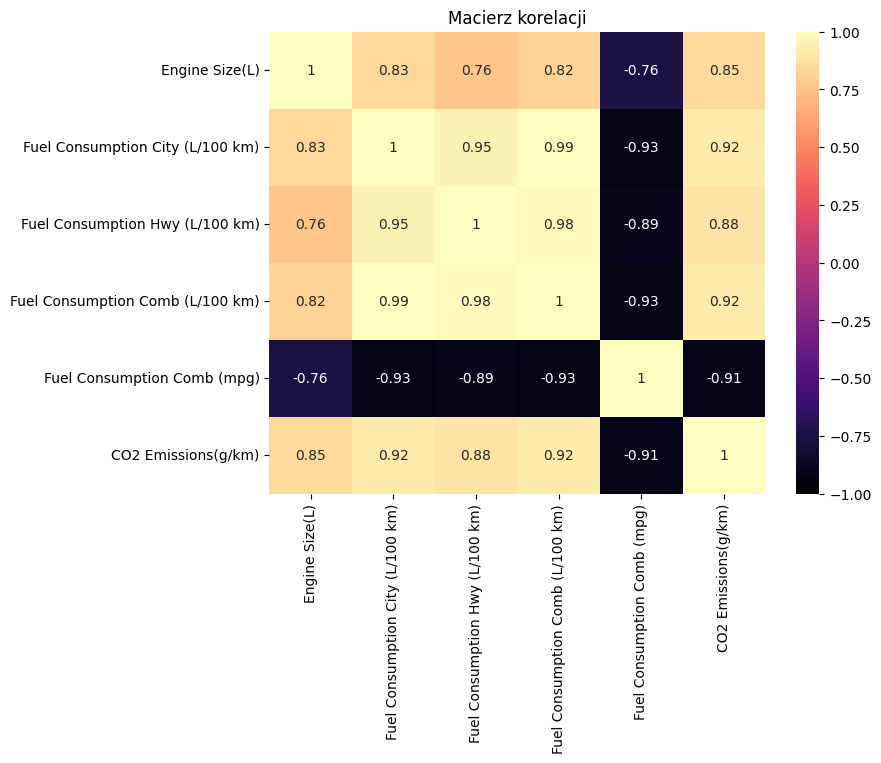

In [31]:
import seaborn as sns


def FindContFeatures(Dataset) -> list[str]:
    """Funkcja zwracaa listę nagłówków cech, które są typu floating-point
    """
    return Dataset.select_dtypes(include = "float").columns.to_numpy()



def CreatePairPlotCont(Dataset:pd.DataFrame, ContFeatures:list[str]) -> None:
    """Utwórz wykres parowy. (to znaczy - dla par zmiennych ciągłych) warunkowy ze względu na typ paliwa.
    """

    sns.pairplot(data = Dataset, vars = ContFeatures, hue = "Fuel Type")



def ComputeAndDrawCorrelationMatrix(Dataset:pd.DataFrame, Num_Features: list[str]) -> np.array:
    """Funkcja ta zajmuje się liczeniem macierzy korelacji między cechami numerycznymi. Dodatkowo, rysuje wykres cieplny, który
    obrazuje te relacje.
    """
    CorrMatrix:pd.DataFrame =  Dataset[Num_Features].corr(method = "pearson")

    plt.figure(figsize=(8, 6))

    sns.heatmap(CorrMatrix, annot=True, cmap='magma', vmin=-1, vmax=1)
    plt.title('Macierz korelacji')
    plt.show()

    return CorrMatrix


ContFeatures = FindContFeatures(Dataset=Dataset)

#CreatePairPlotCont(Dataset, ContFeatures)
CorrMatrix = ComputeAndDrawCorrelationMatrix(Dataset, ContFeatures)

### 6. Dyskretyzacja zmiennej docelowej.

In [41]:

def Discretize(Dataset:pd.DataFrame, target_var:str, bins:list[float]) -> pd.Series:
    labels = [i for i in range(len(bins)+1)]
    bins = [-float("inf")] + bins + [float('inf')]


    discretized_feature = pd.cut(x = Dataset[target_var], 
                                 bins = bins, 
                                 labels = labels)


    Dataset[target_var_discr] = discretized_feature


Discretize(Dataset, target_var, [150, 250])

### Tutaj zakończyliśmy czyszczenie kodu.


### 7. Warunkowe wykresy gęstości prawdopodobieństwa dla zmiennych ciągłych.

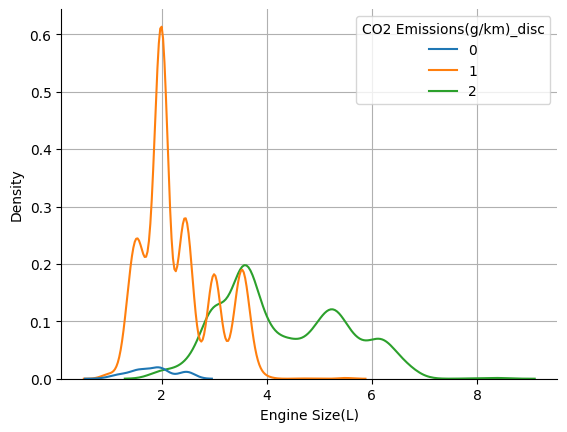

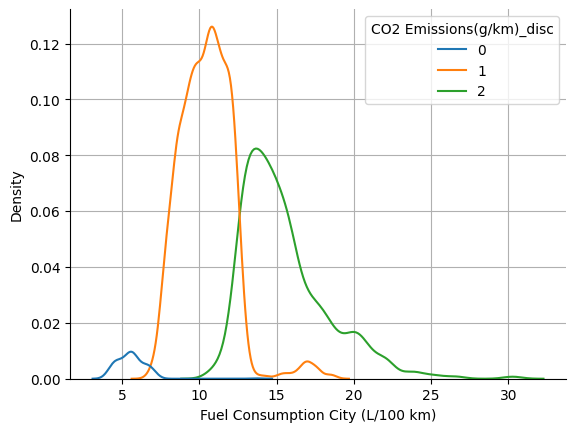

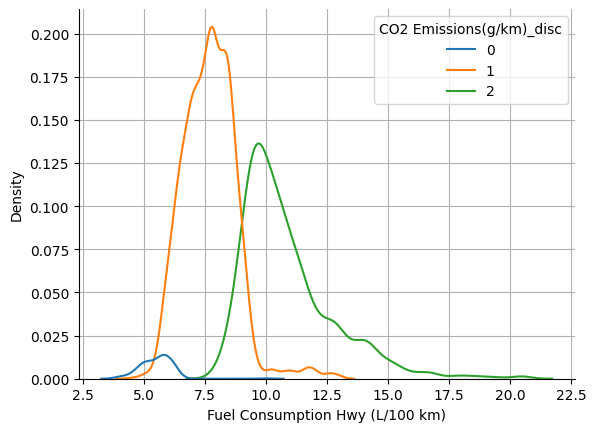

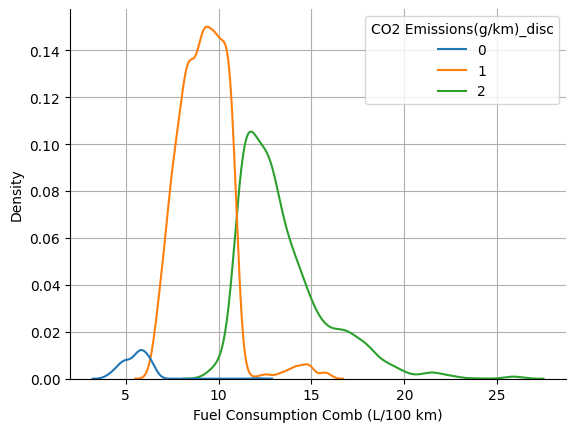

In [15]:
def StwórzWykresKDE(Dataset:pd.DataFrame, ContFeature:str, condfeature:str | None = None) -> plt.axes:
    okno = plt.figure(num  = f"{ContFeature}_kdeplot")
    osie  = okno.add_subplot()

    sns.kdeplot(data = Dataset, x = ContFeature, hue = condfeature, ax = osie) #Narysuj wykres warunkowy.

    osie.grid(True)
    osie.spines[["top","right"]].set_visible(False)

    return osie


for ContFeature in ContFeatures:
    
    StwórzWykresKDE(Dataset, ContFeature, condfeature = target_var_discr)


### Dochodzimy do wniosku, że wszystkie cztery powyższe cechy ciągłe są bardzo dobrze dyskryminującę. Wykresy gęstości prawdopdoobieństwa dla każdej z cech ciągłych są praktycznie rozłączne, nie nachodzą na siebie.

### 8. Wykresy gęstości prawdopodobieństwa cia zmiennych ciągłych

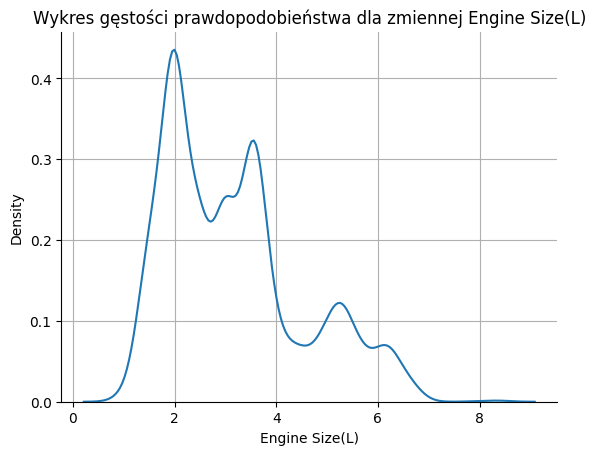

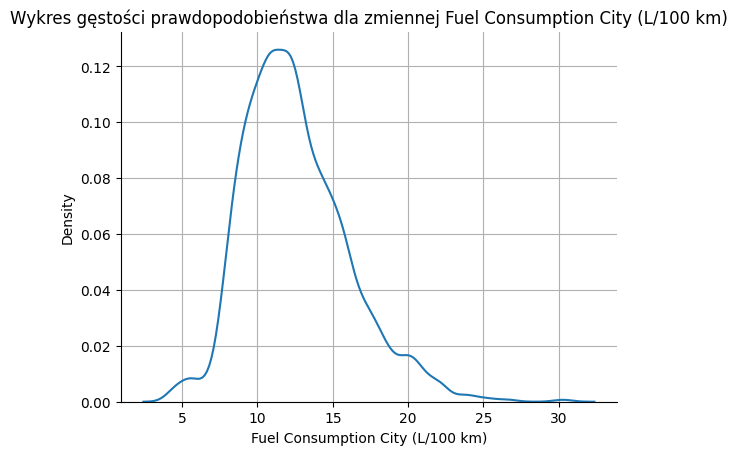

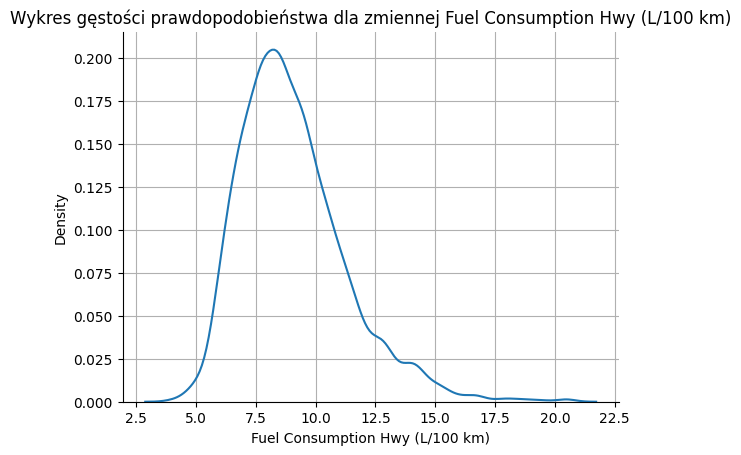

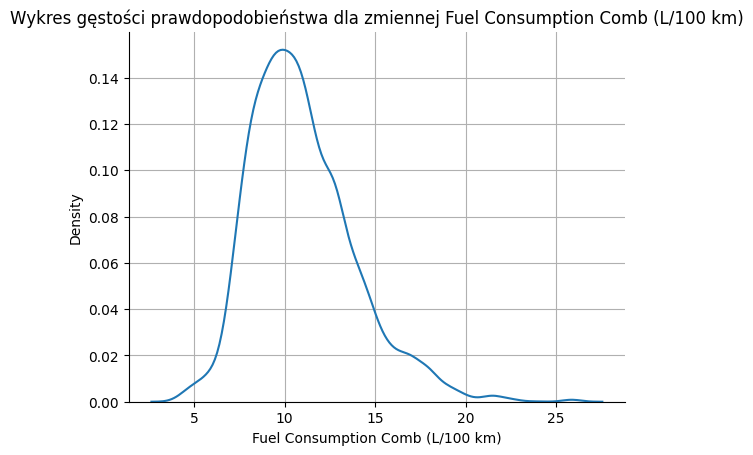

In [16]:
for ContFeature in ContFeatures:
    
    axes = StwórzWykresKDE(Dataset, ContFeature)
    axes.set_title(f"Wykres gęstości prawdopodobieństwa dla zmiennej {ContFeature}")

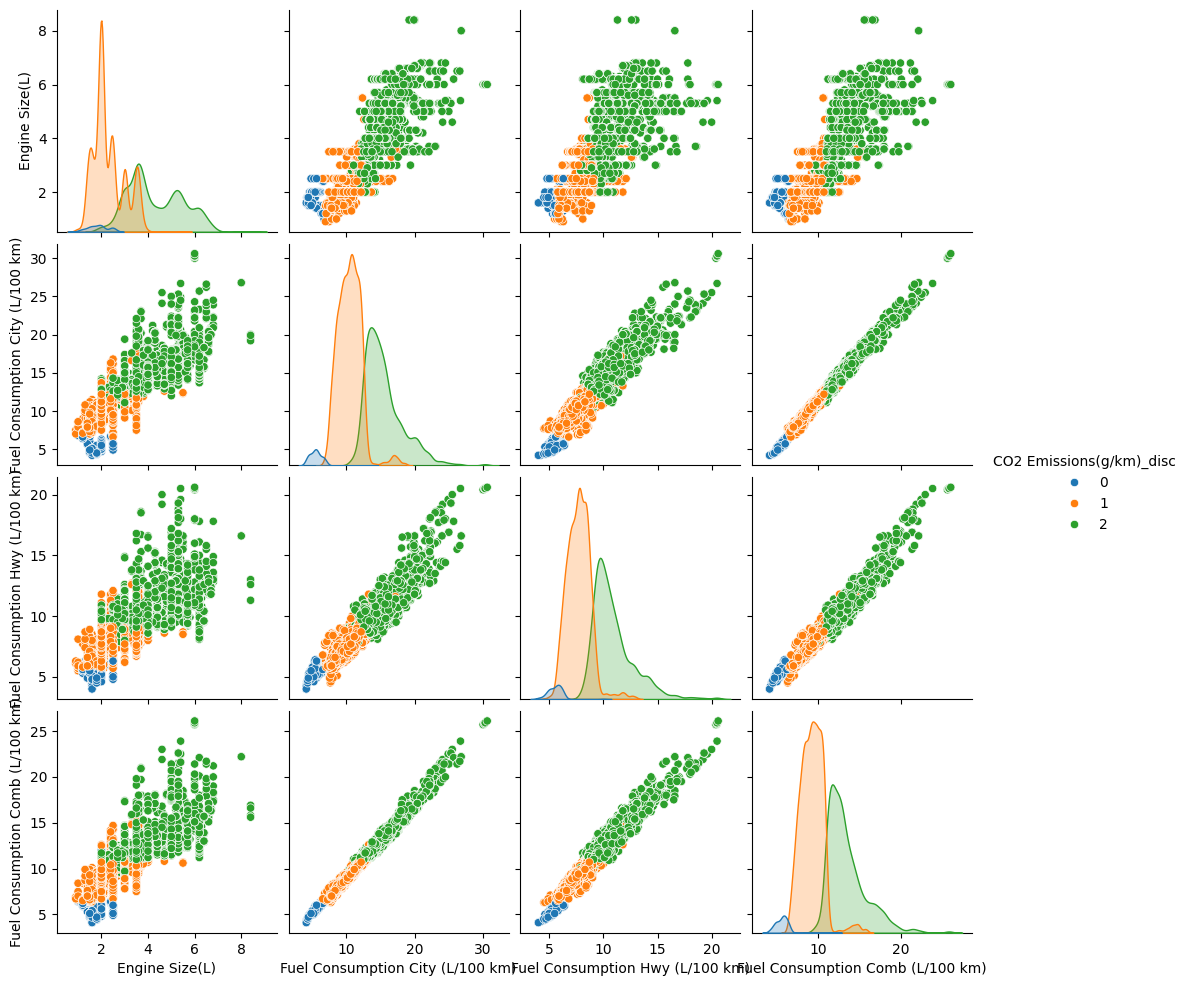

In [17]:
#Teraz stwórz wykres parowy warunkowy ze względu na dyskretną wartość zmiennej docelowej.
sns.pairplot(data = Dataset, vars = ContFeatures , hue = target_var_discr)


### 7. Wykresy pudełkowe dla zmiennych ciągłych.

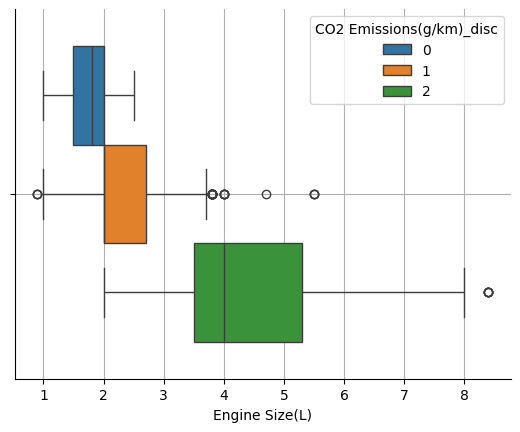

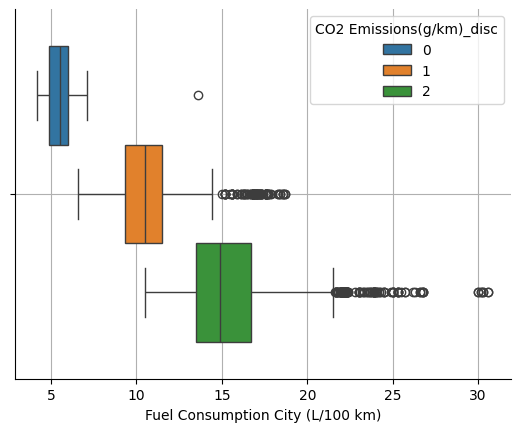

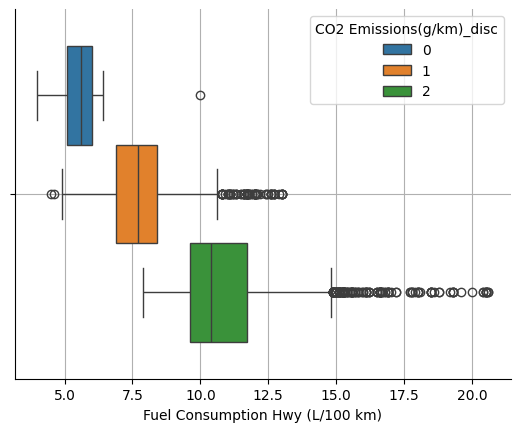

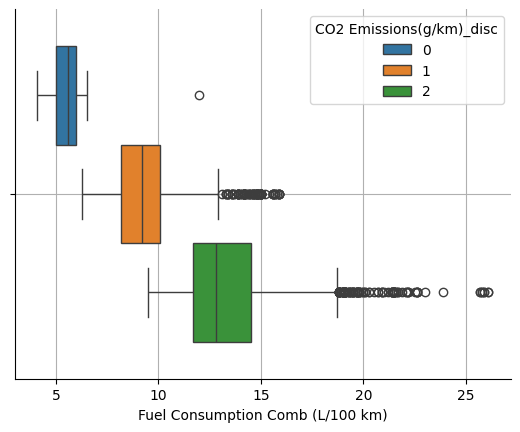

In [18]:
def StwórzWykresPudełkowy(Dataset:pd.DataFrame, ContFeature:str, condfeature:str):
    okno = plt.figure(num  = f"{ContFeature}_kdeplot")
    osie  = okno.add_subplot()

    sns.boxplot(data = Dataset, x = ContFeature, hue = condfeature, ax = osie) #Narysuj wykres pudełkowy..

    osie.grid(True)
    osie.spines[["top","right"]].set_visible(False)


for ContFeature in ContFeatures:
    
    StwórzWykresPudełkowy(Dataset, ContFeature, target_var_discr)

### Powyższe wykresy pudełkowe utwierdzają nas w przekoniu, że te zmienne idealnie spełniają wymagania na bycie predyktorem.

In [19]:
Predictors = ['Make', "Vehicle Class",'Engine Size(L)','Cylinders','Transmission','Fuel Type','Fuel Consumption City (L/100 km)']


print(Predictors)


['Make', 'Vehicle Class', 'Engine Size(L)', 'Cylinders', 'Transmission', 'Fuel Type', 'Fuel Consumption City (L/100 km)']


### 8. Kodowanie zmiennych kategorycznych.

In [20]:
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import OneHotEncoder


def ZakodujDane(Dataset:pd.DataFrame, Predictors:list[str], target_var_discr):
    #Określ zestaw cech predykcyjnych.
    X = Dataset[Predictors]
    #Określ cechę celu. Tę kolumne przekształć do tablicy numpy wymiary (n_samples, 1).
    y = Dataset[target_var_discr].to_numpy().reshape(-1,1)

    #Zdefiniuj transformator. Jest on oparty na koderze OneHotEncoder(). Do przekształcenia bierzemy tylko kolumny kategoryczne. Pozostałe kolumny (zmienne ciągłe) są przekazywane 
    #do wyjściowej ramki zmiennych predykcyjnych bez zmian.
    cat_col_transformer = ColumnTransformer(transformers = 
                                            [('cat',OneHotEncoder(sparse_output = False), make_column_selector(dtype_include=['category','object']))],
                                            remainder = "passthrough",)

    #Przekształć zmienną X za pomocą określonego wyżej transformatora.
    X_coded = cat_col_transformer.fit_transform(X = X)



In [21]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate


#Zdefiniuj pierwszy model
Model = DecisionTreeClassifier(criterion = "gini", 
                                    splitter = "best", min_samples_split = 10,)


#Podziel zbiór  na testowy i treningowy
X_coded_train, X_coded_test, y_train, y_test = train_test_split(X_coded, y, 
                                                                train_size = 0.8, test_size = 0.2, random_state = 1 )


#Wytrenuj model.
Model.fit(X = X_coded_train, 
          y = y_train)

#A następnie zbadaj modelu efektywność, obliczająć metrykę o nazwie dokładność.
Accuracy = Model.score(X = X_coded_test, 
            y = y_test)

print(Accuracy)


#Walidacja krzyżowa.

#Określ liczbę iteracji:
cv_n = 5
iterations = np.arange(1, cv_n+1, dtype = np.int16)

CV = cross_validate(estimator = Model, X = X_coded, y = y, scoring = "accuracy", cv = cv_n)
scores = CV['test_score']

print(scores)

0.967501692620176
[0.95192959 0.96682464 0.97088693 0.97224103 0.95192959]


### Zaprezentuj wyniki dla drzewka klasyfikacyjnego na wykresie liniowym oraz na histogramie oraz na wykresie pudełkowym.

Text(0.5, 1.0, 'Wykres rozrzutu wartości dokładności dla Drzewka Decyzyjnego')

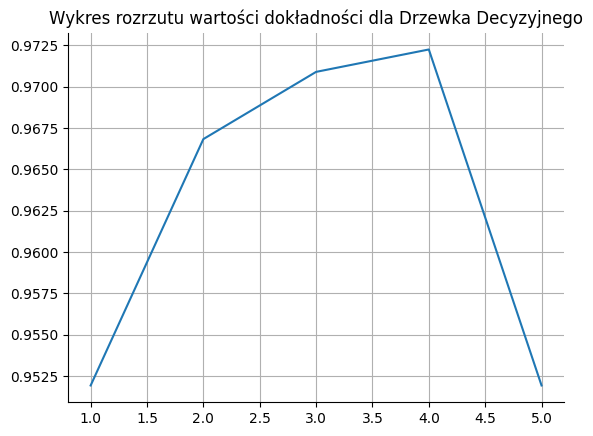

In [22]:


TreeLineAxes = sns.lineplot(x = iterations,  y = scores, markers = 'dotted')

TreeLineAxes.grid(True)
TreeLineAxes.spines[['top','right']].set_visible(False)

TreeLineAxes.set_title("Wykres rozrzutu wartości dokładności dla Drzewka Decyzyjnego")



Text(0.5, 1.0, 'Wykres pudełkowy wartości dokładności dla Drzewka Decyzyjnego')

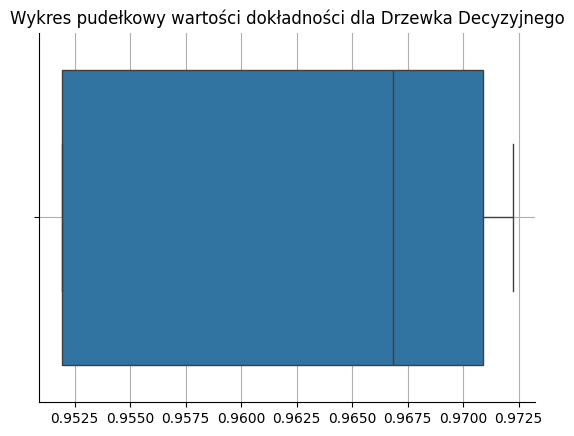

In [23]:
TreeBoxAxes = sns.boxplot(x = scores)

TreeBoxAxes.spines[['top','right']].set_visible(False)
TreeBoxAxes.grid(True)


TreeBoxAxes.set_title(f"Wykres pudełkowy wartości dokładności dla Drzewka Decyzyjnego")

Text(0.5, 1.0, 'Histogram wartości dokładności dla Drzewka Decyzyjnego')

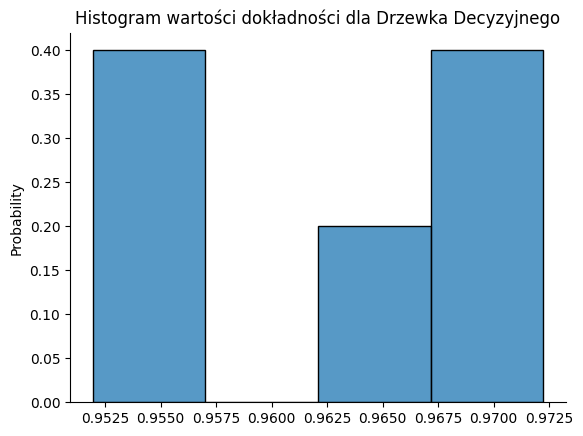

In [24]:
TreeHistAxes = sns.histplot(x = scores, stat = "probability")


TreeHistAxes.spines[['top','right']].set_visible(False)

TreeHistAxes.set_title(f"Histogram wartości dokładności dla Drzewka Decyzyjnego")